In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pointprocesses as ppr

In [97]:
import torch

In [98]:
torch.manual_seed(1)

In [99]:
import os
import sys

In [100]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
print("Notebook dir {:}".format(nb_dir))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

Notebook dir /home/manifold/Documents/etudes/map511-p3a


In [101]:
sys.path

['',
 '/home/manifold/Documents/etudes/map511-p3a/notebooks',
 '/home/manifold/miniconda3/envs/pytorch/lib/python37.zip',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7/lib-dynload',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/pointprocesses-0.3.1-py3.7-linux-x86_64.egg',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions',
 '/home/manifold/.ipython',
 '/home/manifold/Documents/etudes/map511-p3a']

# Synthetic data

In [7]:
def intensity_function_(t, lam0, alpha, beta, history):
    return lam0 + np.sum(alpha*beta*np.exp(-beta*(t - history))*(t >= history), axis=0)

intensity_function = np.vectorize(intensity_function_, excluded={4})

In [8]:
import itertools
mu = 1.0
tmax = 10.0
alpha = 0.4
beta  = 1.5

print("Expected avg evt no. %.3f" % (tmax*mu/(1.-alpha)))

Expected avg evt no. 16.667


In [9]:
n_traj = 400
sample_trajectories = [ppr.hawkes_exp(tmax, beta, mu, itertools.repeat(alpha)) for _ in range(n_traj)]

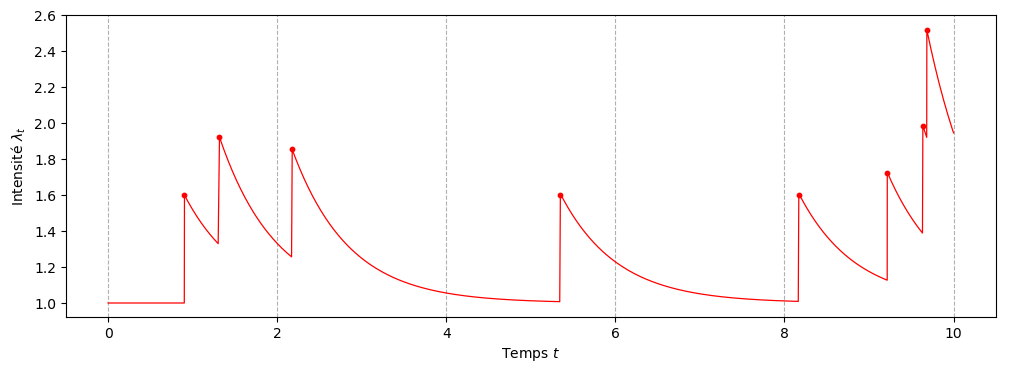

In [10]:
one_traj = sample_trajectories[0]
fig, ax = plt.subplots(1,1, figsize=(12,4), dpi=100)
ax.set_xlabel("Temps $t$")
ax.set_ylabel(r"Intensité $\lambda_t$")
t_arr = np.sort(np.append(np.linspace(0, tmax, 600), one_traj[:,]))
ax.plot(t_arr, intensity_function(t_arr, mu, alpha, beta, one_traj[:,0]), 'r-', linewidth=0.9)
ax.xaxis.set_major_locator(mticker.MultipleLocator(2.))
scatter_opts = {
    "c": "r", "s": 11
}
ax.grid(True, axis='x', linestyle='--')
ax.scatter(one_traj[:,0], one_traj[:,1], c='r', s=10)

We will pad each sequence with 0s at the end.

In [11]:
print("Number of samples: \t\t%d" % len(sample_trajectories))
seq_lengths = torch.LongTensor([s.shape[0] for s in sample_trajectories])+1
input_size = seq_lengths.max().item()
print("Input size max. traj. length: \t%d" % input_size)
print("tmax = %.3f"  % tmax)
data_array = np.stack([
    np.pad(s[:,0], ((0, input_size - s.shape[0] - 1)), 'constant') for s in sample_trajectories
])
data_tensor = torch.from_numpy(data_array).to(torch.float32)

# Add a beginning-of-sequence event:
data_tensor = torch.cat((torch.zeros(data_tensor.shape[0],1), data_tensor), dim=1)

Number of samples: 		400
Input size max. traj. length: 	40
tmax = 10.000


Text(0, 0.5, 'Number')

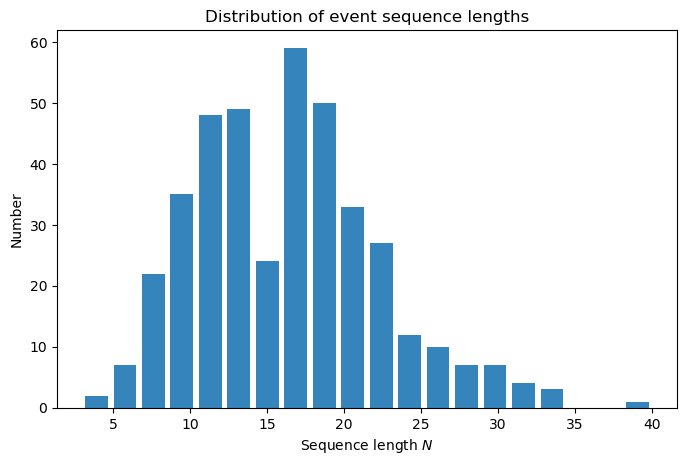

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
ax.hist(seq_lengths, bins=2*int(seq_lengths.size(0)**(2/5)), rwidth=0.8, alpha=0.9)
ax.set_title('Distribution of event sequence lengths')
ax.set_xlabel('Sequence length $N$')
ax.set_ylabel('Number')

In [13]:
data_tensor.shape

torch.Size([400, 40])

The first dimension is for time, the second for the sample.

## Neural network

In [14]:
import torch
import torch.nn as nn
from torch import optim

In [15]:
device = torch.device("cpu")
print(device)

cpu


The intensity process is given by
$$
    \lambda_k(t) = f_k(\mathbf w_\alpha\mathbf h(t) + \mathbf b_\alpha)
$$
with $\mathbf h(t)$ the hidden state, defined from the cell state $\mathbf c(t)$ :
$$
    \mathbf h(t) = \mathbf o_i \odot \tanh(\mathbf c(t))\in\mathbb R^D,\quad t\in(t_{i-1}, t_i].
$$

with
$$
    \mathbf c(t) = \bar{\mathbf c}_{i+1} + (\mathbf c_{i+1} - \bar{\mathbf c}_{i+1})\exp\left(-\delta_{i+1}(t-t_i)\right),\quad t\in(t_{i-1}, t_i].
$$

In [503]:
from models.ctlstm import NeuralCTLSTM
from train_functions import train_neural_ctlstm
import tqdm

In [504]:
# We use mini-batches to train on our data
BATCH_SIZE = 40
print("Batch size: %d" % BATCH_SIZE)
print("Training sample size: %d" % data_tensor.size(0))
print("Splitting into batches of %d" % BATCH_SIZE)
split_into_batches = data_tensor.split(BATCH_SIZE, dim=0)
num_of_batches = len(split_into_batches)
print("No. of batches: %d" % num_of_batches)

hidden_size = 12
learn_rate = 0.0015

nhlstm = NeuralCTLSTM(hidden_size)
optimizer = optim.SGD(nhlstm.parameters(), lr=learn_rate)

Batch size: 40
Training sample size: 400
Splitting into batches of 40
No. of batches: 10


Each training loop:
* reinitializes the hidden states
* zeroes the gradients
* computes the loss

In [505]:
# batch_range = tqdm.trange(num_of_batches)
# batch_range = tqdm.trange(data_tensor.size(0))
train_size = 400
batch_range = tqdm.tqdm_notebook(range(train_size))
loss_hist = []
for i in batch_range:
    batch_range.set_description("Batch %d" % (i+1))
    # sample's event times
    event_times = data_tensor[i]
    loss, hists_ = train_neural_ctlstm(nhlstm, optimizer, event_times, seq_lengths[i], input_size, tmax)
    loss_val = loss.item()
    batch_range.set_postfix(loss=loss_val)
    loss_hist.append(loss_val) # record the loss value

In [506]:
hists_.keys()

dict_keys(['output', 'hidden', 'cell_state', 'cell_target', 'decay_cell'])

In [507]:
nhlstm.decay_gate.weight

Parameter containing:
tensor([[ 0.1325,  0.0894, -0.0985,  0.1839,  0.1556, -0.0035,  0.1301,  0.2813,
         -0.0389,  0.0385, -0.0126,  0.2805]], requires_grad=True)

Text(0.5, 1.0, 'Training: Evolution of the cell decay')

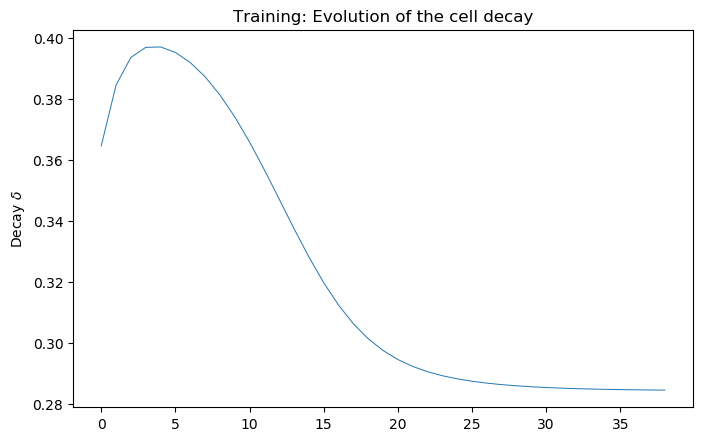

In [508]:
# Retrieve all cell decay values
plt.figure(figsize=(8,5), dpi=100)
plt.plot(hists_['decay_cell'].detach().numpy()[0,:,0], linewidth=.7)
plt.ylabel('Decay $\delta$')
plt.title("Training: Evolution of the cell decay")

Text(0.5, 0, 'Training samples')

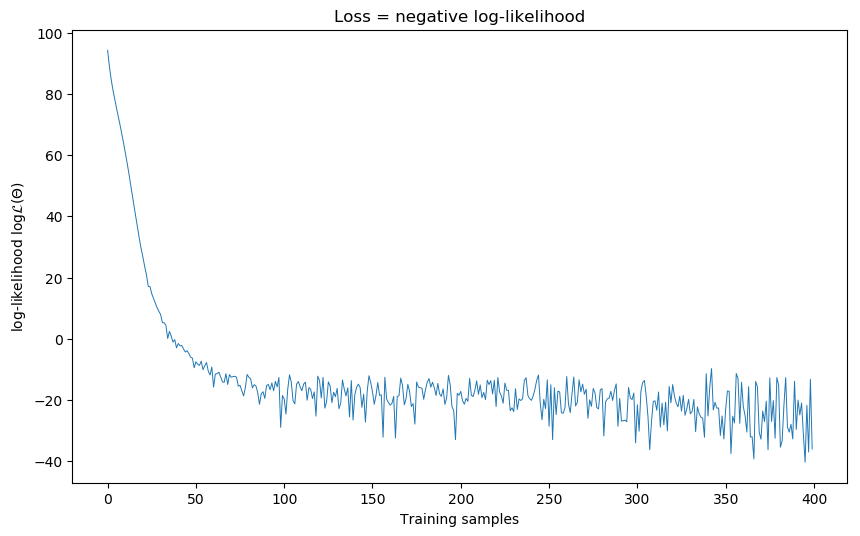

In [509]:
fig, ax = plt.subplots(1, 1, figsize=(10,6), dpi=100)

lineopts = {
    "linewidth": 0.7
}
ax.plot(range(train_size), loss_hist, **lineopts)
ax.set_title("Loss = negative log-likelihood")
ax.set_ylabel(r'log-likelihood $\log\mathcal{L}(\Theta)$')
ax.set_xlabel("Training samples")

In [468]:
import datetime

In [249]:
ts = '{:%Y%m%d-%H%M%S}'.format(datetime.datetime.now())

flname = '{:}-{:}.pth'.format(nhlstm.__class__.__name__, ts)
print(flname)
fpath = '../saved_models/{:}'.format(flname)
print(fpath)

torch.save(nhlstm.state_dict(), fpath)

NeuralCTLSTM-20181110-200118.pth
../saved_models/NeuralCTLSTM-20181110-200118.pth


## Event generation

In [510]:
import models.ctlstm
from models.ctlstm import CTGenerator

In [511]:
nhlstm.eval()
print(nhlstm.training)

False


In [512]:
neural_gen = CTGenerator(nhlstm)

In [513]:
neural_gen.generate_sequence(tmax)

Increment: 2.0623693466186523
Intensity 0.5417115092277527
	lbda_max	0.5765281319618225
	ratio	0.9396098852157593
Increment: 0.8603899478912354
Intensity 0.9289632439613342
	lbda_max	0.5765281319618225
	ratio	1.611306071281433
Increment: 0.24253275990486145
Intensity 1.295411467552185
	lbda_max	0.9670494198799133
	ratio	1.339550495147705
Increment: 0.11377548426389694
Intensity 1.6365867853164673
	lbda_max	1.3162778615951538
	ratio	1.2433444261550903
Increment: 0.31892964243888855
Intensity 1.9353408813476562
	lbda_max	1.6535942554473877
	ratio	1.1703842878341675
Increment: 0.3178599774837494
Intensity 2.2552480697631836
	lbda_max	1.9813286066055298
	ratio	1.138250470161438
Increment: 0.9895610809326172
Intensity 2.4612088203430176
	lbda_max	2.3118033409118652
	ratio	1.0646271705627441
Increment: 0.32540014386177063
Intensity 2.9211721420288086
	lbda_max	2.652566909790039
	ratio	1.1012624502182007
Increment: 0.5793584585189819
Intensity 3.2059268951416016
	lbda_max	3.0052926540374756
	

[2.0623693466186523,
 2.9227592945098877,
 3.165292054414749,
 3.279067538678646,
 3.5979971811175346,
 3.915857158601284,
 4.905418239533901,
 5.230818383395672,
 5.810176841914654,
 6.303866945207119,
 6.382270969450474,
 6.386850357521325,
 6.745119393337518,
 6.84548543440178,
 6.855053430888802,
 7.05462226876989,
 7.081040006596595,
 7.122587137389928,
 7.132571461144835,
 7.306716161314398,
 7.742972927633673,
 7.7881010682322085,
 7.9406719715334475,
 8.157673037145287,
 8.225476330611855,
 8.357929816935211,
 8.38767157541588,
 8.529502004850656,
 8.876511067617685,
 9.026331291068345,
 9.055234037805349,
 9.228859298396856,
 9.345432073343545,
 9.456261069048196,
 9.486994661856443,
 9.535581954289228,
 9.555038050282747,
 9.67474138038233,
 9.819718771148473]

In [514]:
print(len(neural_gen.sequence_))

39


In [515]:
neural_gen.hidden_hist[0]

{'hidden': tensor([[ 0.0185,  0.0377,  0.0271,  0.0132,  0.0016, -0.0958,  0.0374,  0.0326,
          -0.1006,  0.0514, -0.1263, -0.0239]]),
 'cell': tensor([[ 0.0365,  0.0668,  0.0466,  0.0222,  0.0029, -0.1620,  0.0758,  0.0574,
          -0.1577,  0.1070, -0.2209, -0.0525]]),
 'cell_target': tensor([[ 0.0401,  0.0708,  0.0512,  0.0215,  0.0022, -0.1965,  0.0756,  0.0483,
          -0.1255,  0.0956, -0.2121, -0.0654]]),
 'cell_decay': tensor([[0.3643]]),
 'output': tensor([[0.5074, 0.5651, 0.5829, 0.5945, 0.5715, 0.5962, 0.4948, 0.5689, 0.6430,
          0.4820, 0.5808, 0.4562]])}

In [516]:
neural_gen.hidden_hist[-1]

{'hidden': tensor([[-0.7383,  0.7450,  0.5286, -0.8176, -0.6558, -0.8804,  0.7081,  0.3822,
          -0.8066,  0.4618, -0.8085, -0.0481]]),
 'cell': tensor([[-1.9994,  1.4745,  1.3537, -2.2451, -2.0242, -2.5285,  2.3079,  0.8697,
          -2.3529,  0.9697, -2.1861, -0.0948]]),
 'cell_target': tensor([[-0.7901,  0.6861,  0.9328, -0.7325, -0.7612, -0.6029,  0.8901,  0.4153,
          -0.5232,  0.7814, -0.8114, -0.1161]]),
 'cell_decay': tensor([[0.2839]]),
 'output': tensor([[0.7659, 0.8274, 0.6042, 0.8361, 0.6791, 0.8916, 0.7223, 0.5451, 0.8213,
          0.6169, 0.8292, 0.5094]])}

Text(0.5, 1.0, 'Evolution of the cell decay with each event')

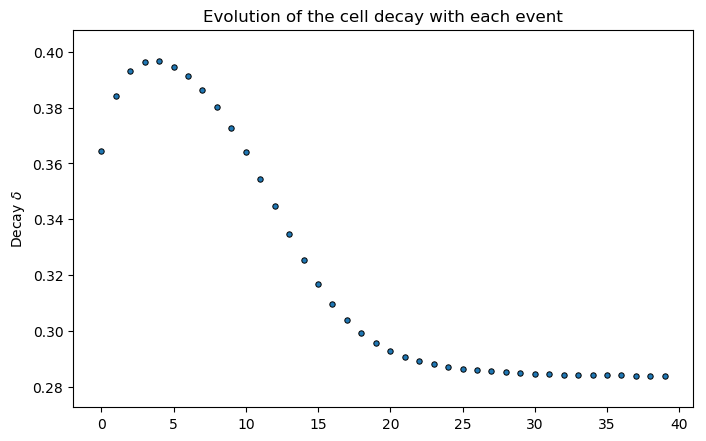

In [517]:
# Retrieve all cell decay values
all_decay_vals = [el['cell_decay'] for el in neural_gen.hidden_hist]
plt.figure(figsize=(8,5), dpi=100)
plt.scatter(np.array(range(len(all_decay_vals))), np.array(all_decay_vals),
            s=15, edgecolor='k', linewidth=.7)
plt.ylabel('Decay $\delta$')
plt.title("Evolution of the cell decay with each event")

In [518]:
time_vals, intens_vals = neural_gen.make_ctlstm_sequence_plot(200, tmax)

Text(0.5, 1.0, 'Intensity plot for neural Hawkes process')

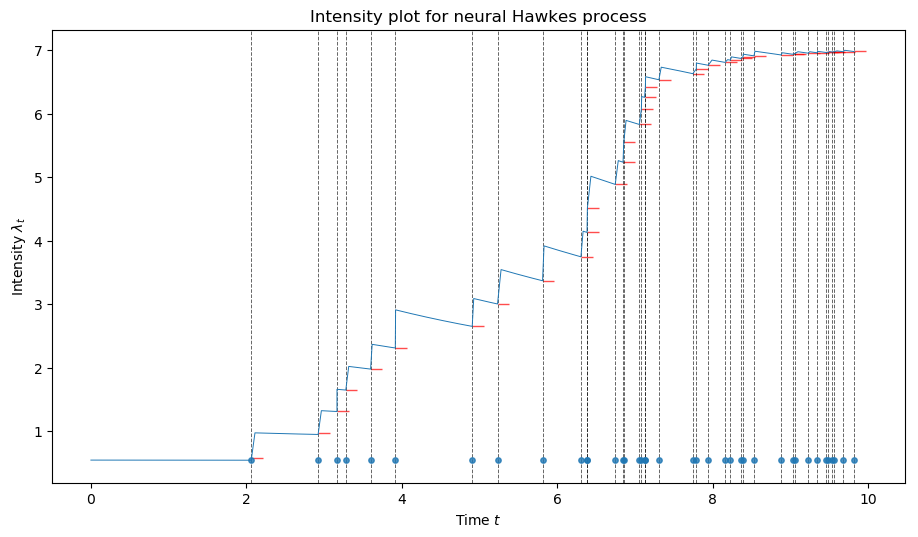

In [519]:
fig, ax = plt.subplots(1, 1, figsize=(11, 6), dpi=100)
ax.plot(time_vals, intens_vals, linewidth=0.7)
for i,t in enumerate(neural_gen.sequence_):
    lbd = neural_gen.lbda_max_seq_[i+1]
    ax.axvline(t, ymin=0.0, ymax=intens_vals.max(), linewidth=0.7,
               linestyle='--',
               alpha=0.6, c='k', zorder=-1)
    ax.hlines(lbd.item(), xmin=t, xmax=t+0.15, colors='r',
              linewidth=1.0, alpha=0.7, zorder=-1)

ax.scatter(neural_gen.sequence_, intens_vals.min() + np.zeros_like(neural_gen.sequence_),
           s=15, alpha=0.8, zorder=1, )
ax.set_xlabel("Time $t$")
ax.set_ylabel("Intensity $\lambda_t$")
ax.set_title("Intensity plot for neural Hawkes process")